In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import pickle
import warnings
import numpy as np
import pylab as plt

from astropy.io import fits
from natsort import natsorted
from astropy.stats import sigma_clip

# Make sure we can find lassi-analysis
import sys
sys.path.append('/home/scratch/psalas/LASSI/lassi-analysis_v2')

from grid import regridXYZ
from lassiAnalysis import loadLeicaData
from plotting import surfacePlot, barChartPlot
from zernikies import getZernikeCoeffsOLS, getZernikeCoeffs
from analyzeActiveSurface import processActiveSurfaceFITSPair
from utils.utils import gridLimits, midPoint, stride, rolling_std
from analysis.March2020.zernike import make_aperture_efficiency, aperture_efficiency_residuals

In [3]:
def zernikeOLS(x, y, z, nZern):

    # Use WLS to determine the Zernike coefficients.
    dz_s = stride(z.filled(np.nan), r_c=(4,4))
    dz_std = rolling_std(dz_s, no_null=False)
    dz_std_pad = np.pad(dz_std, ((2,1),(2,1)), mode='constant', constant_values=np.nan)
    dz_std_pad = np.ma.masked_where(dz_std_pad <= 20e-6, dz_std_pad)
    w = np.power(dz_std_pad, -2.)
    w = np.ma.masked_invalid(w)
    x_ = np.ma.masked_invalid(x-midPoint(x))
    y_ = np.ma.masked_invalid(y-midPoint(y))
    fl_wls = getZernikeCoeffsOLS(x_, y_, z, nZern, weights=w)
    
    return fl_wls

In [4]:
n = 512
nZern = 36
scanDir = '/home/scratch/psalas/LASSI/gpus/output/'
ref_scans = ['2020_03_16_02:21:06',
             '2020_03_16_02:54:59',
             '2020_03_16_03:19:50',
             '2020_03_16_03:44:25',
             '2020_03_16_04:09:06',
             '2020_03_16_04:33:33',
             '2020_03_16_04:58:03',
             '2020_03_16_05:22:24',
             '2020_03_16_05:47:09',
             '2020_03_16_06:11:20',
             '2020_03_16_06:35:42',
             '2020_03_16_07:00:20',
             '2020_03_16_07:24:39',
             '2020_03_16_07:48:47',
             '2020_03_16_08:12:50',
             '2020_03_16_08:37:03',
             '2020_03_16_09:01:35',
            ]
# Use the .zernike.fits files to select signal scans.
fitsDir = '/home/gbtdata/TLASSI_200315'
zern_files = natsorted(glob.glob("{0}/LASSI/*.zernike.fits".format(fitsDir)))[3:]

In [5]:
refScanFile = "{0}/{1}.ptx.csv".format(scanDir, ref_scans[7])
orgData, cleanData = loadLeicaData(refScanFile, n=n, numpy=False)
xr = orgData[0]
yr = orgData[1]
zr = orgData[2]

In [6]:
%%time

zFitDict = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i,ff in enumerate(zern_files):

        sf = ff.replace(".zernike.fits", ".fits")
        sigScanFile = "{0}/{1}".format(scanDir, sf.split('/')[-1].replace('.fits', '.ptx.csv'))

        # Find the scan number.
        hdu = fits.open(sf)
        head = hdu[0].header
        scan = head['SCAN']

        orgData, cleanData = loadLeicaData(sigScanFile, n=n, numpy=False)
        xs = orgData[0]
        ys = orgData[1]
        zs = orgData[2]
        
        xmin, xmax = gridLimits(xs, xr)
        ymin, ymax = gridLimits(ys, yr)

        xrg, yrg, zrg = regridXYZ(xr, yr, zr, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
        xsg, ysg, zsg = regridXYZ(xs, ys, zs, n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

        diff = zsg - zrg
        diff = sigma_clip(diff)

        fl_wls = zernikeOLS(xsg, ysg, diff, nZern)
        fl = getZernikeCoeffs(diff.filled(0)[::-1].T, nZern, norm='active-surface')

        zFitDict[scan] = {'recovered zernike': fl,
                          'recovered zernike wls': fl_wls,
                         }

CPU times: user 2min 48s, sys: 34.4 s, total: 3min 22s
Wall time: 2min 10s


In [7]:
%%time

asDict = {}

# Use the .zernike.fits files to select signal scans.
zern_files = natsorted(glob.glob("{0}/LASSI/*.zernike.fits".format(fitsDir)))[3:]

# Load the ScanLog
hdu = fits.open("{0}/ScanLog.fits".format(fitsDir))
scanArr = hdu[1].data

for i, zf in enumerate(zern_files):

    hdu = fits.open(zf)
    head = hdu[0].header
    scan = head['MC_SCAN']

    idx = np.where(scanArr['SCAN'] == scan)[0][0]
    idx_as = idx - 3
    sig_scan = scanArr['SCAN'][idx_as]
    ref_scan = scanArr['SCAN'][idx_as-6]

    # Load the AS fits file for the signal scan.
    as_file = file = '/'.join(scanArr[idx_as]['FILEPATH'].split('/')[-2:])
    hdu = fits.open("{0}/{1}".format(fitsDir, as_file))
    z_as = hdu[1].data['value']

    # The AS Zernike contents start at Z1, not Z0.
    # The LASSI Zernike start at Z0.
    z_idx = int(np.where(z_as != 0)[0])

    as_file_sig = '/'.join(scanArr[idx_as]['FILEPATH'].split('/')[-2:])
    as_file_ref = '/'.join(scanArr[idx_as - 6]['FILEPATH'].split('/')[-2:])
    #print(as_file_sig, as_file_ref)
    xas, yas, aas, aar, fitlist = processActiveSurfaceFITSPair("{0}/{1}".format(fitsDir, as_file_ref), 
                                                               "{0}/{1}".format(fitsDir, as_file_sig), 
                                                               column='ABSOLUTE', filterDisabled=True, 
                                                               verbose=False, plot=False)
    z_as_obs = fitlist

    z_in = z_as[z_idx]
    z_in_as = z_as_obs[z_idx+1]*1e6 # microns

    asDict[scan] = {'input zernike': z_idx + 1,
                    'input zernike value': z_as[z_idx],
                    'active surface zernike value': z_in_as,
                    'active surface reference scan': ref_scan,
                    'active surface signal scan': sig_scan,
                         }

CPU times: user 37.8 s, sys: 4.35 s, total: 42.1 s
Wall time: 33.5 s


In [8]:
%%time
zindxs = [4, 7, 13]
zcoefs = np.arange(0., 500., 10.)*1e-6 # m
eps_tot, eta_tot = make_aperture_efficiency(zindxs, zcoefs, n=256)

CPU times: user 43.2 s, sys: 0 ns, total: 43.2 s
Wall time: 43.2 s


In [9]:
%%time

zin = np.zeros(len(zern_files), dtype=np.float)
zobs = np.zeros((len(zern_files),2), dtype=np.float)
zinval = np.zeros(len(zern_files), dtype=np.float)
residuals = np.zeros((len(zern_files),2), dtype=np.float)

for i,k in enumerate(natsorted(list(zFitDict.keys()))):
    
    zi = asDict[k]['input zernike']
    ci = asDict[k]['active surface zernike value']
    ci_obs = zFitDict[k]['recovered zernike'][zi]
    ci_obs_wls = zFitDict[k]['recovered zernike wls'][zi]
    
    zin[i] = zi
    zinval[i] = ci
    zobs[i,0] = ci_obs
    zobs[i,1] = ci_obs_wls
    residuals[i,0] = abs(ci - ci_obs)
    residuals[i,1] = abs(ci - ci_obs_wls)

CPU times: user 510 µs, sys: 0 ns, total: 510 µs
Wall time: 522 µs


In [10]:
eta_res = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,0]*1e6)
eta_res_wls = aperture_efficiency_residuals(zindxs, zcoefs*1e6, eta_tot, zin, zinval, zobs[:,1]*1e6)

In [21]:
zinval

array([-516.38741635, -495.41999069, -158.37373698,  -62.69683515,
       -539.19572847, -144.01590003,  -55.12263541, -535.39426496,
       -175.55972332,  -57.1759742 , -552.08557173, -193.76977608,
        -86.13387749, -546.66244406, -178.05195627,  -83.0480965 ,
       -533.94010907])

<IPython.core.display.Javascript object>


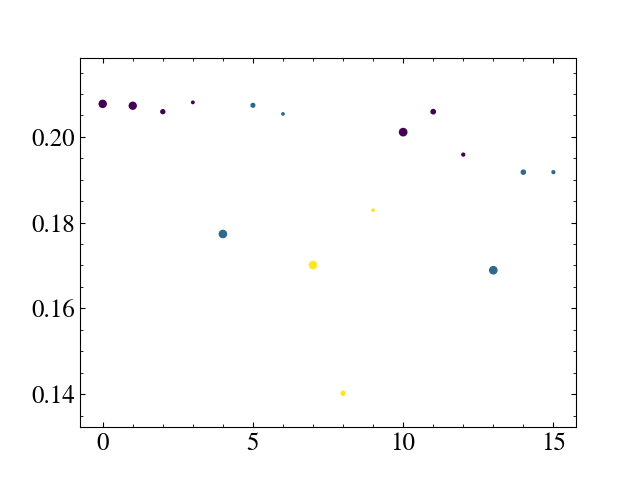

In [39]:
plt.figure()

plt.scatter(np.arange(0, len(eta_res)-1), eta_res[:-1], c=zin[:-1], s=abs(zinval[:-1])/20.)
#plt.plot(eta_res_wls, 'b.')
plt.minorticks_on()
plt.tick_params('both', direction='in', which='both', top=True, right=True, left=True, bottom=True)

In [12]:
zinval

array([-516.38741635, -495.41999069, -158.37373698,  -62.69683515,
       -539.19572847, -144.01590003,  -55.12263541, -535.39426496,
       -175.55972332,  -57.1759742 , -552.08557173, -193.76977608,
        -86.13387749, -546.66244406, -178.05195627,  -83.0480965 ,
       -533.94010907])

In [13]:
zobs[:,0]*1e6

array([-540.34335414, -466.82925533, -205.82577367,  -67.54097759,
       -404.02213696, -165.86444109,  -16.03671817, -485.04927448,
       -103.88581166,  -19.47842257, -466.50984727, -138.85626237,
         36.97536313, -385.9705708 ,  -82.67966069,   13.33069353,
       -314.84408349])

In [14]:
zobs[:,1]*1e6

array([-442.72618763, -443.93681159,  -79.50322511,   59.52647469,
       -622.06854811, -140.26838285,  -83.9364634 , -685.29604823,
       -112.11915312,  -16.22737598, -635.99182003, -116.8663805 ,
         54.96660761, -437.21110832, -159.14489226,  -91.29344281,
       -602.02480963])

In [41]:
idx = 4
print(zin[idx], zinval[idx], zobs[idx]*1e6)

7.0 -539.1957284650651 [-404.02213696 -622.06854811]


In [36]:
print(eta_tot.max(), eta_res[:-1].mean(), np.power(eta_res[:-1].mean()/eta_tot.max(), -2.))

0.20804304085861067 0.1917136029401888 1.177607404650314


<IPython.core.display.Javascript object>


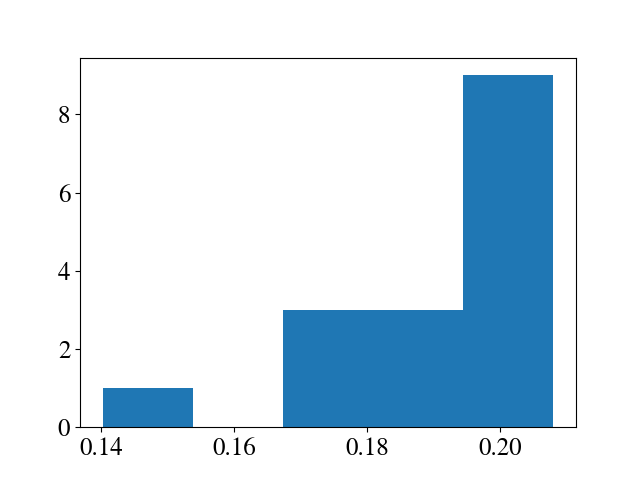

(array([1., 0., 3., 3., 9.]),
 array([0.14021103, 0.15377744, 0.16734384, 0.18091024, 0.19447664,
        0.20804304]),
 <a list of 5 Patch objects>)

In [35]:
plt.figure()
plt.hist(eta_res[:-1], bins='auto')

In [37]:
1.17*60.

70.19999999999999